# Tutorial: Neal's funnel

This tutorial demonstrates modeling and running inference on the so-called Neal's funnel model in Bean Machine.

Neal's funnel has proven difficult-to-handle for classical inference methods. This tutorial demonstrates how to overcome this by using second-order gradient methods in Bean Machine. It also demonstrates how to implement models with factors in Bean Machine through custom distributions.

## Problem

Neal's funnel is a synthetic model that is fairly simple, but has proven challenging for automatic inference engines to handle due to its unusual geometry. This model has an unfavorable, exponential geometry in one direction, and a narrow "funnel" bending into that direction.

## Prerequisites

Let's model this in Bean Machine! Import the Bean Machine library and some fundamental PyTorch classes.

In [1]:
import beanmachine.ppl as bm
from beanmachine.ppl.inference.proposer.single_site_hamiltonian_monte_carlo_proposer import (
    SingleSiteHamiltonianMonteCarloProposer,
)
from beanmachine.ppl.inference.proposer.single_site_newtonian_monte_carlo_proposer import (
    SingleSiteNewtonianMonteCarloProposer,
)

import torch
from torch import tensor
import torch.distributions as dist
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rc('figure', figsize=[8, 6])
plt.rc('font', size=14)
plt.rc('lines', linewidth=2.5)

pd.set_option('precision', 3)

torch.manual_seed(11);

## Model

[Neal's funnel](https://projecteuclid.org/euclid.aos/1056562461) is defined mathematically as follows:

* $z \sim \mathcal{N}(0, 3)$
* $x \sim \mathcal{N}(0, e^{z/2})$

Let's visualize the model's density. To do this, we recognize that the joint density is factored as follows:

* $P(z, x) = \mathcal{N}(x; 0, e^{z/2}) \cdot \mathcal{N}(z; 0, 3)$

In [2]:
xs, zs = torch.meshgrid(
    torch.arange(-50, 50, 0.1),
    torch.arange(-15.0, 15.0, 0.1),
)
density = (
    dist.Normal(0.0, (zs / 2.0).exp()).log_prob(xs).exp() *
    dist.Normal(0.0, 3.0).log_prob(zs).exp()
)

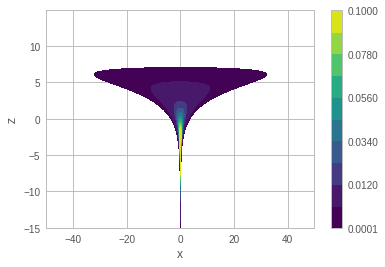

In [3]:
plt.contourf(xs, zs, density, levels=[0.0001] + torch.linspace(0.001, 0.1, 10).tolist())
plt.xlabel('x')
plt.ylabel('z')
plt.colorbar();

Plotting the log density is usually easier to visualize and reason about.

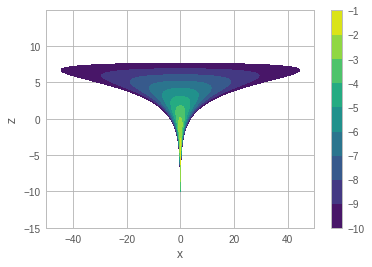

In [4]:
plt.contourf(xs, zs, density.log(), levels=range(-10, 0))
plt.xlabel('x')
plt.ylabel('z')
plt.colorbar();

As we can see, the funnel’s neck is particularly sharp because of the exponential function applied to $z$. The density decays exponentially the farther that $x$ deviates from $0$. This makes it challenging to learn a good scale for proposal updates. Let's go about modeling this in Bean Machine!

Compared to many of the other tutorials, this one is more of a contrived model. In the typical problem setup found in other tutorials, there are ground-truth values that we're trying to infer distributions about based on observed data. In this case, however, we're trying to exactly replicate a ground-truth _distribution_, by using the mechanics of the Bean Machine inference engine to guide the sampling process.

Since Neal's funnel describes a mathematical relationship instead of a generative process, we'll have to reframe it into a generative process in order to run inference on it. We'll do this as follows:

  1. Sample priors for $z$ and $x$.
  2. Imagine weighting the probabilities of $z$ and $x$ according to how likely they are under the true Neal's funnel model. We can do this by imagining we're flipping a coin, where the probability of it landing heads is the probability of drawing that $z$ and $x$ from the Neal's funnel model, but where we've actually _observed_ it to be heads.
  3. Later, we will inform the inference engine that we observed heads. This will cause the engine to find values for $z$ and $x$ that are consistent with samples from the true Neal's funnel posterior -- since those are the samples that would have resulted in the observed "heads" from our coin flip!
  
<div style="background: #daeaf3; border-left: 3px solid #2980b9; display: block; margin: 16px 0; padding: 12px;">
  A few notes for advanced readers (feel free to skip over these):
  <ul>
    <li>In the above statistical model, we already _had_ definitions for $z \sim \mathcal{N}(0, 3)$ and $x \sim \mathcal{N}(0, e^{z/2})$. We are free to reuse these definitions as priors. However, that's giving inference an unfair advantage, since our priors exactly match our posterior. Instead, in this tutorial we will choose noninformative priors.
    <li>It is common to refer to this coin-flipping approach as a "factor". Traditionally, PPLs have been implemented by weighting a particular run of inference according to the log probability of that run of inference. We're exactly doing that in this model -- based on a particular draw of $z$ and $x$, we're weighting that overall run by the probability that those values would have been sampled from the true Neal's funnel posterior.
  </ul>
</div>
  
We can implement this model in Bean Machine by defining random variable objects with the `@bm.random_variable` decorator. These functions behave differently than ordinary Python functions.

<div style="background: #daeaf3; border-left: 3px solid #2980b9; display: block; margin: 16px 0; padding: 12px;">
  Semantics for <code>@bm.random_variable</code> functions:
  <ul>
    <li>They must return PyTorch <code>Distribution</code> objects.
    <li>Though they return distributions, callees actually receive <i>samples</i> from the distribution. The machinery for obtaining samples from distributions is handled internally by Bean Machine.
    <li>Inference runs the model through many iterations. During a particular inference iteration, a distinct random variable will correspond to exactly one sampled value: <b>calls to the same random variable function with the same arguments will receive the same sampled value within one inference iteration</b>. This makes it easy for multiple components of your model to refer to the same logical random variable.
    <li>Consequently, to define distinct random variables that correspond to different sampled values during a particular inference iteration, an effective practice is to add a dummy "indexing" parameter to the function. Distinct random variables can be referred to with different values for this index.
    <li>Please see the documentation for more information about this decorator.
  </ul>
</div>

In [5]:
@bm.random_variable
def z():
    """
    An uninformative (flat) prior for z.
    """
    # TODO(tingley): Replace with Flat once it's part of the framework.
    return dist.Normal(0, 10000)

@bm.random_variable
def x():
    """
    An uninformative (flat) prior for x.
    """
    # TODO(tingley): Replace with Flat once it's part of the framework.
    return dist.Normal(0, 10000)

@bm.random_variable
def neals_funnel_coin_flip():
    """
    Flip a "coin", which is heads with probability equal to the probability
    of drawing z and x from the true Neal's funnel posterior.
    """
    return dist.Bernoulli(
        (
            dist.Normal(0.0, (z() / 2.0).exp()).log_prob(x()) +
            dist.Normal(0.0, 3.0).log_prob(z())
        ).exp()
    )

# Inference

Inference is the process of combining _model_ with _data_ to obtain _insights_, in the form of probability distributions over values of interest. Bean Machine offers a powerful and general inference framework to enable fitting arbitrary models to data.

As discussed in the previous section, we'll pretend that we've observed heads when flipping a coin whose heads rate is weighted according to how likely the z and x values were to be drawn from the true Neal's funnel posterior. Let's set that up right now.

Our inference algorithms expect observations in the form of a dictionary. This dictionary should consist of `@bm.random_variable` invocations as keys, and tensor data as values.

In [6]:
observations={ neals_funnel_coin_flip(): tensor(1.0) }

Next, we'll run inference on the model and observations.

Since this model is comprised entirely of differentiable random variables, we'll make use of the Newtonian Monte Carlo (NMC) inference method. NMC is a second-order method, which uses the Hessian to automatically scale the step size in each dimension. The hope is that this inference method will take the exponential growth rate of Neal's funnel into account, and explore the entire posterior surface, including the neck of the funnel. Check out the documentation for more information on NMC.

Running inference consists of a few arguments:

| Name | Usage
| --- | ---
| `queries` | A list of `@bm.random_variable` targets to fit posterior distributions for.
| `observations` | The `Dict` of observations we built up, above.
| `num_samples` | Number of samples to build up distributions for the values listed in `queries`.
| `num_chains` | Number of separate inference runs to use. Multiple chains can verify inference ran correctly.

Let's run inference:

In [7]:
single_site_nmc_samples = bm.SingleSiteNewtonianMonteCarlo().infer(
    queries=[ z(), x() ],
    observations=observations,
    num_samples=1000,
    num_chains=4,
)

Samples collected: 100%|██████████| 1000/1000 [00:13<00:00, 72.81it/s]


## Analysis

`samples` now contains our inference results.

In [8]:
z_marginal = single_site_nmc_samples[ z() ].flatten().detach()
x_marginal = single_site_nmc_samples[ x() ].flatten().detach()

print(
    f"z_marginal: {z_marginal}\n"
    f"x_marginal: {x_marginal}"
)

z_marginal: tensor([-2.1991, -1.2706, -1.2706,  ...,  1.9198,  1.1361,  2.9408])
x_marginal: tensor([-0.1557, -0.1774,  0.8283,  ..., -0.9199,  2.8244,  5.5872])


Let's plot our inferred posterior, along with the marginal distributions for $z$ and $x$.

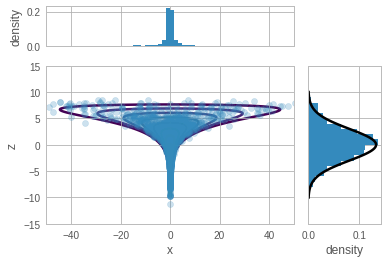

In [9]:
grid = mpl.gridspec.GridSpec(4, 4)

plt.subplot(grid[1:, :3])
plt.contour(xs, zs, density.log(), levels=range(-10, 0), zorder=0)
plt.scatter(x_marginal, z_marginal, alpha=0.25)
plt.xlabel("x")
plt.ylabel("z")
plt.xlim(-50, 50)
plt.ylim(-15, 15)

plt.subplot(grid[0, :3])
plt.hist(x_marginal, bins=60, density=True, range=(-50, 50))
plt.ylabel("density")
plt.xlim(-50, 50)
plt.gca().axes.get_xaxis().set_ticklabels([])

plt.subplot(grid[1:, 3])
zs_marginal = torch.linspace(-10, 10, 100)
plt.hist(z_marginal, bins=30, density=True, range=(-15, 15), orientation="horizontal")
plt.plot(dist.Normal(0, 3).log_prob(zs_marginal).exp(), zs_marginal, color="black")
plt.xlabel("density")
plt.ylim(-15, 15)
plt.gca().axes.get_yaxis().set_ticklabels([]);

The samples appear to match the correct posterior well! Inference also seems to have successfully fit the $z$ marginal, which is analytically known.

Bean Machine provides a Diagnostics package that provides helpful statistics about the result of the inference algorithm. We can query this information as follows:

In [10]:
bm.Diagnostics(single_site_nmc_samples).summary()

,avg,std,2.5%,50%,97.5%,r_hat,n_eff
x()[],-0.325,9.432,-14.982,-0.008,11.640,1.000,3202.989
z()[],0.163,3.212,-6.108,0.211,6.998,1.009,107.228


$z$ and $x$ have means very close to zero, which is expected. $x$ as a much higher standard deviation than $z$, which is expected as well. The quantiles give useful insights into the spread of the two variables.

The diagnostics output shows two diagnostic statistics: [$\hat{R}$](https://projecteuclid.org/euclid.ss/1177011136) (`r_hat`) and [$N_\text{eff}$](https://www.mcmchandbook.net/HandbookChapter1.pdf) (effective sample size, `n_eff`).

  * $\hat{R} \in [1, \infty)$ summarizes how effective inference was at converging on the correct posterior distribution for a particular random variable. It uses information from all chains run in order to assess whether inference had a good understanding of the distribution or not. Values very close to zero indicate that all chains discovered similar distributions for a particular random variable. We do not recommend using inference results where $\hat{R} > 1.1$, as inference may not have converged. In that case, you may want to run inference for more samples.
  * $N_\text{eff} \in [1, \texttt{num}\_\texttt{samples}]$ summarizes how independent posterior samples are from one another. Although inference was run for `num_samples` iterations, it's possible that those samples were very similar to each other (due to the way inference is implemented), and may not each be representative of the full posterior space. Larger numbers are better here, and if your particular use case calls for a certain number of samples to be considered, you should ensure that $N_\text{eff}$ is at least that large.
  
In this case, $\hat{R}$ and $N_\text{eff}$ seem to have acceptable values.

Bean Machine can also plot diagnostical information to assess model fit. Let's take a look:

In [11]:
bm.Diagnostics(single_site_nmc_samples).plot(display=True);

The diagnostics output shows two diagnostic plots for individual random variables: trace plots and autocorrelation plots.

  * Trace plots are simply a time series of values assigned to random variables over each iteration of inference. The concrete values assigned are usually problem-specific. However, it's important that these values are "mixing" well over time. This means that they don't tend to get stuck in one region for large periods of time, and that each of the chains ends up exploring the same space as the other chains throughout the course of inference.
  * Autocorrelation plots measure how predictive the last several samples are of the current sample. Autocorrelation may vary between -1.0 (deterministically anticorrelated) and 1.0 (deterministically correlated). (We compute autocorrelation approximately, so it may sometimes exceed these bounds.) In an ideal world, the current sample is chosen independently of the previous samples: an autocorrelation of zero. This is not possible in practice, due to stochastic noise and the mechanics of how inference works.

From the autocorrelation plots, we see the absolute mangitude of autocorrelation tends to be quite small. The trace plots are a little more suspicious, especially for $x$. Let's take a deeper look at the spike in chain 3. Here, if we look at the corresponding trace plot for $z$ at this time, we see that it is exploring large outlier values for $z$, around 6 or greater. We expect $x$ to have high variance when $z$ is large, so this is as expected.

This concludes the main Neal's funnel tutorial! However, we'll also walk through the same model using Hamiltonian Monte Carlo inference to compare relative performance.

## Appendix: Single-site Hamiltonian Monte Carlo

Hamiltonian Monte Carlo is a classic gradient-based inference method. HMC proceeds by taking a sequence of steps towards the gradient, but with some injected noise, before proposing a candidate sample. Bean Machine provides a single-site implementation of HMC that we can use to fit Neal's funnel. Check out our documentation for more information on HMC.

In [12]:
single_site_hmc_samples = bm.SingleSiteHamiltonianMonteCarlo(
    path_length=0.1,
    step_size=0.01,
).infer(
    queries=[ z(), x() ],
    observations=observations,
    num_samples=1000,
    num_chains=4,
)

Samples collected: 100%|██████████| 1000/1000 [00:37<00:00, 26.81it/s]


In [13]:
z_marginal = single_site_hmc_samples[ z() ].flatten().detach()
x_marginal = single_site_hmc_samples[ x() ].flatten().detach()

print(
    f"z_marginal: {z_marginal}\n"
    f"x_marginal: {x_marginal}"
)

z_marginal: tensor([0.1487, 0.1386, 0.1355,  ..., 2.5700, 2.5021, 2.4310])
x_marginal: tensor([-0.0704, -0.1288,  0.0306,  ...,  3.9927,  4.0126,  4.1724])


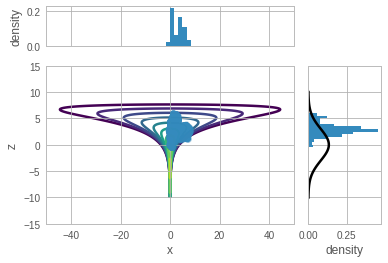

In [14]:
grid = mpl.gridspec.GridSpec(4, 4)

plt.subplot(grid[1:, :3])
plt.contour(xs, zs, density.log(), levels=range(-10, 0), zorder=0)
plt.scatter(x_marginal, z_marginal, alpha=0.25)
plt.xlabel("x")
plt.ylabel("z")
plt.xlim(-50, 50)
plt.ylim(-15, 15)

plt.subplot(grid[0, :3])
plt.hist(x_marginal, bins=60, density=True, range=(-50, 50))
plt.ylabel("density")
plt.xlim(-50, 50)
plt.gca().axes.get_xaxis().set_ticklabels([])

plt.subplot(grid[1:, 3])
zs_marginal = torch.linspace(-10, 10, 100)
plt.hist(z_marginal, bins=60, density=True, range=(-15, 15), orientation="horizontal")
plt.plot(dist.Normal(0, 3).log_prob(zs_marginal).exp(), zs_marginal, color="black")
plt.xlabel("density")
plt.ylim(-15, 15)
plt.gca().axes.get_yaxis().set_ticklabels([]);

As we can see, HMC isn't able to fully explore values for $z$, which prevents it from correctly recovering the posterior. We can confirm that HMC hasn't mixed well by examining the $\hat{R}$ values:

In [15]:
bm.Diagnostics(single_site_hmc_samples).summary()

,avg,std,2.5%,50%,97.5%,r_hat,n_eff
x()[],3.107,2.228,-0.103,3.493,7.112,3.002,2.413
z()[],2.917,1.238,0.174,2.849,5.534,1.848,6.938


And the unhealthy trace and autocorrelation plots:

In [16]:
bm.Diagnostics(single_site_hmc_samples).plot(display=True);

## Appendix: Metropolis-Adjusted Langevin Algorithm

The Metropolis-Adjusted Langevin Algorithm (MALA) is a special case of HMC, where only a single gradient step is taken before proposing a sample. Let's try it on Neal's funnel.

In [17]:
single_site_mala_samples = bm.SingleSiteHamiltonianMonteCarlo(
    path_length=0.5,
    step_size=0.5,
).infer(
    queries=[ z(), x() ],
    observations=observations,
    num_samples=2000,
    num_chains=4,
)

Samples collected: 100%|██████████| 2000/2000 [00:20<00:00, 98.15it/s]


In [18]:
z_marginal = single_site_mala_samples[ z() ].flatten().detach()
x_marginal = single_site_mala_samples[ x() ].flatten().detach()

print(
    f"z_marginal: {z_marginal}\n"
    f"x_marginal: {x_marginal}"
)

z_marginal: tensor([-0.1074,  0.0582,  0.8848,  ..., -1.8543, -1.2734, -1.1629])
x_marginal: tensor([-0.0110,  0.1179,  0.6187,  ...,  0.4363,  0.7215,  1.4018])


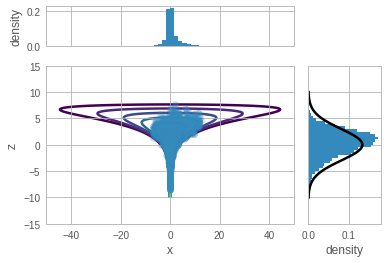

In [19]:
grid = mpl.gridspec.GridSpec(4, 4)

plt.subplot(grid[1:, :3])
plt.contour(xs, zs, density.log(), levels=range(-10, 0), zorder=0)
plt.scatter(x_marginal, z_marginal, alpha=0.25)
plt.xlabel("x")
plt.ylabel("z")
plt.xlim(-50, 50)
plt.ylim(-15, 15)

plt.subplot(grid[0, :3])
plt.hist(x_marginal, bins=60, density=True, range=(-50, 50))
plt.ylabel("density")
plt.xlim(-50, 50)
plt.gca().axes.get_xaxis().set_ticklabels([])

plt.subplot(grid[1:, 3])
zs_marginal = torch.linspace(-10, 10, 100)
plt.hist(z_marginal, bins=60, density=True, range=(-15, 15), orientation="horizontal")
plt.plot(dist.Normal(0, 3).log_prob(zs_marginal).exp(), zs_marginal, color="black")
plt.xlabel("density")
plt.ylim(-15, 15)
plt.gca().axes.get_yaxis().set_ticklabels([]);

Interestingly, MALA seems capable of fitting Neal's funnel better than HMC!

## Appendix: Global Hamiltonian Monte Carlo

To implement global HMC, we would like to use block inference for $z$ and $x$. If our inference proposes a new value for $z$, it will also jointly propose a new value for $x$.

We configure block inference using the method `add_sequential_proposer`, which takes a list of variables as an argument. Note that, unlike in typical Bean Machine syntax, we don't include arguments to variable objects when defining the block inference scheme. This is because the framework can compute the minimal _specific_ set of variables to update from the random variable families provided to this function. The next paragraph explains how that block selection is performed, and is quite technical! Feel free to skip it if desired.

<div style="background: #daeaf3; border-left: 3px solid #2980b9; display: block; margin: 16px 0; padding: 12px;">
  Block inference selects specific subsets of random variables to update jointly. This is based upon which variables would typically be included in one another's Markov blanket during a single-site update. The Markov blanket of a random variable is a statistical concept defining which  other random variables may be directly affected when we propose a new value for the current random variable. It includes the current random variable's parents, children, and parents-of-children. Therefore, <code>z</code> and <code>x</code> <i>always</i> end up blocked together in this simple example. Our single-site inference typically runs inference individually for <code>z</code> and <code>x</code>, doing separate accept-reject procedures for each individual node of the probabilistic model. With block inference, before computing the accept-reject probability on <code>z</code>, the method will search the Markov blanket of <code>z</code> to find all variables that would be directly affected by an update to <code>z</code>. In this case, <code>x</code> will be blocked together with <code>z</code>, since that's what we configured with <code>add_sequential_proposer</code>. New proposals for <i>all</i> of these variables will be jointly accepted or rejected together. Read more about block inference in our documentation.
</div>

In [20]:
global_hmc_inference_strategy = bm.CompositionalInference({
    z: SingleSiteHamiltonianMonteCarloProposer(path_length=0.1, step_size=0.01),
    x: SingleSiteHamiltonianMonteCarloProposer(path_length=0.1, step_size=0.01),
})
global_hmc_inference_strategy.add_sequential_proposer([z, x])
global_hmc_samples = global_hmc_inference_strategy.infer(
    queries=[ z(), x() ],
    observations=observations,
    num_samples=1000,
    num_chains=4,
)

Samples collected: 100%|██████████| 1000/1000 [01:10<00:00, 14.09it/s]


z_marginal: tensor([ 0.0485, -0.0462, -0.0401,  ...,  5.4571,  5.5758,  5.5738])
x_marginal: tensor([ 0.2385,  0.2216, -0.1826,  ...,  5.8611,  5.6345,  5.4536])


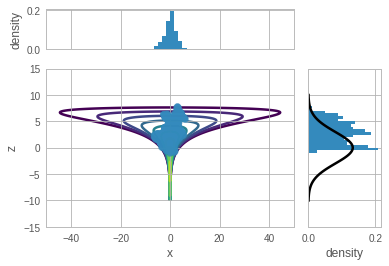

In [21]:
z_marginal = global_hmc_samples[ z() ].flatten().detach()
x_marginal = global_hmc_samples[ x() ].flatten().detach()

print(
    f"z_marginal: {z_marginal}\n"
    f"x_marginal: {x_marginal}"
)

grid = mpl.gridspec.GridSpec(4, 4)

plt.subplot(grid[1:, :3])
plt.contour(xs, zs, density.log(), levels=range(-10, 0), zorder=0)
plt.scatter(x_marginal, z_marginal, alpha=0.25)
plt.xlabel("x")
plt.ylabel("z")
plt.xlim(-50, 50)
plt.ylim(-15, 15)

plt.subplot(grid[0, :3])
plt.hist(x_marginal, bins=60, density=True, range=(-50, 50))
plt.ylabel("density")
plt.xlim(-50, 50)
plt.gca().axes.get_xaxis().set_ticklabels([])

plt.subplot(grid[1:, 3])
zs_marginal = torch.linspace(-10, 10, 100)
plt.hist(z_marginal, bins=60, density=True, range=(-15, 15), orientation="horizontal")
plt.plot(dist.Normal(0, 3).log_prob(zs_marginal).exp(), zs_marginal, color="black")
plt.xlabel("density")
plt.ylim(-15, 15)
plt.gca().axes.get_yaxis().set_ticklabels([]);

This yields similar results to single-site HMC inference.